In [1]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Training a Digit Classifier

FastAI has a set of saved URLs:

In [2]:
URLs.MNIST_SAMPLE

'https://s3.amazonaws.com/fast-ai-sample/mnist_sample.tgz'

FastAI adds an `ls` function, that returns a list of files and displays its length

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)
path.ls()

(#3) [Path('/home/felipe/.fastai/data/mnist_sample/train'),Path('/home/felipe/.fastai/data/mnist_sample/labels.csv'),Path('/home/felipe/.fastai/data/mnist_sample/valid')]

Now we set `/.` to be `path`, effectively `cd path`

In [4]:
Path.BASE_PATH = path
path.ls()

(#3) [Path('train'),Path('labels.csv'),Path('valid')]

The MNIST dataset follows a common layout for machine learning datasets: separate folders for the training set and the validation set (and/or test set). Let's see what's inside the training set:

In [5]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

This dataset only has training images for digits 3 and 7

In [6]:
(path/'train'/'3').ls()

(#6131) [Path('train/3/10921.png'),Path('train/3/1981.png'),Path('train/3/12446.png'),Path('train/3/47653.png'),Path('train/3/33145.png'),Path('train/3/48139.png'),Path('train/3/41404.png'),Path('train/3/26629.png'),Path('train/3/19734.png'),Path('train/3/21946.png')...]

More convenient:

In [7]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
sevens

(#6265) [Path('train/7/10002.png'),Path('train/7/1001.png'),Path('train/7/10014.png'),Path('train/7/10019.png'),Path('train/7/10039.png'),Path('train/7/10046.png'),Path('train/7/10050.png'),Path('train/7/10063.png'),Path('train/7/10077.png'),Path('train/7/10086.png')...]

Lets look at one of the images:

In [8]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [9]:
type(im3)

PIL.PngImagePlugin.PngImageFile

We can see `im3` as a two-dimensional array as well

In [10]:
array(im3)

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  29, 150, 195, 254, 255, 254, 176, 193, 150,  96,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  48, 166, 224, 253, 253, 234, 196, 253, 253, 253, 253, 233,   0

In [11]:
tensor(im3)

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,  29, 150, 195, 254, 255, 254, 176, 193, 150,  96,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,  48, 166, 224, 253, 253, 234, 196, 253, 253, 253, 253, 2

We can load that `tensor` into a Pandas `DataFrame`:

In [12]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0,0,0,0,0,0,0


## Baseline: Pixel similarity

Create an average image for each number, out of the images we have. Then, to determine if any new image is 3 or 7 we measure the distance between that new image and the average images of 3 and 7, respectively. The new image is then classified as the number to which its distance is the smallest. 

First lets get a tensor for each image:

In [30]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

Note that `seven_tensors` and `three_tensors` are lists of rank-2 tensors:

In [33]:
seven_tensors[1].shape

torch.Size([28, 28])

We want to stack all the rank-2 tensors in the list into one rank-3 tensor:

In [35]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens.shape

torch.Size([6265, 28, 28])

Now we get an average `3` by calculating the mean on the first axis (dimension 0) of the rank-3 tensor:

(<AxesSubplot:>, <AxesSubplot:>)

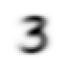

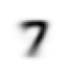

In [37]:
mean3 = stacked_threes.mean(0)
mean7 = stacked_sevens.mean(0)
show_image(mean3), show_image(mean7)